<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Alireza Abbasian
### Student ID: 402200253

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

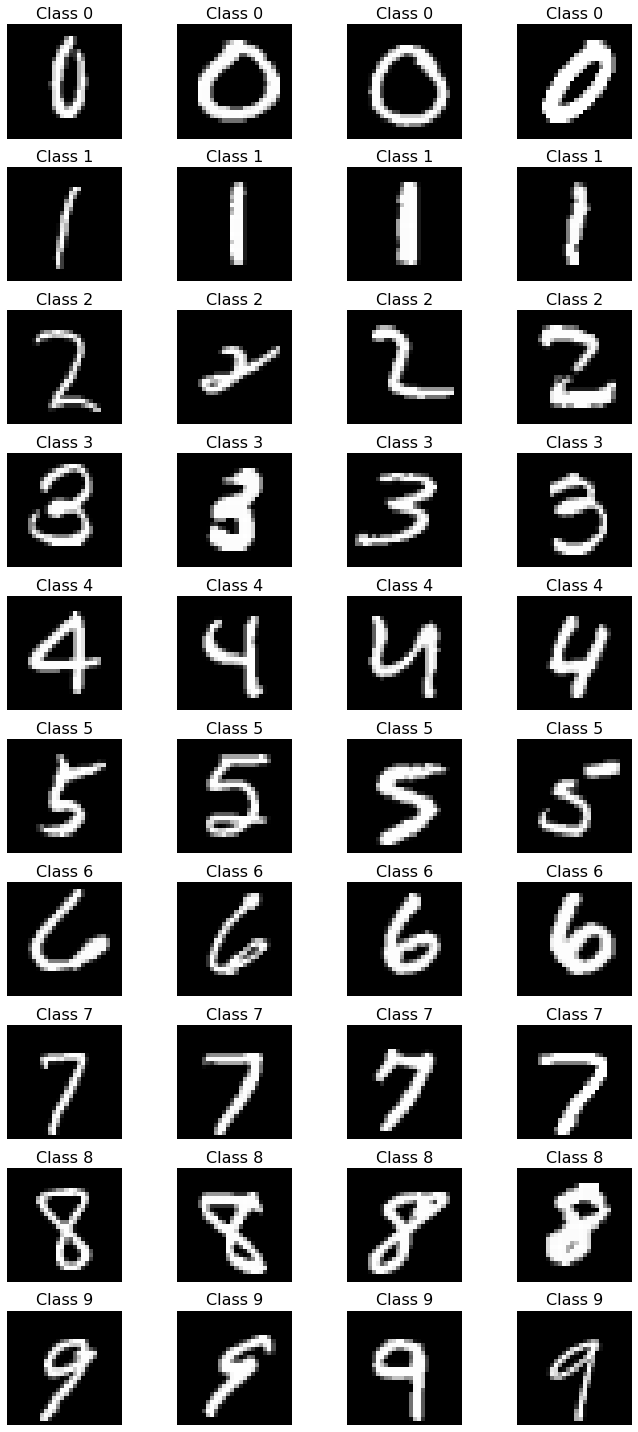

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()

        encoder_layers = []
        encoder_layers.append(nn.Linear(input_dim, hidden_dim[0]))
        encoder_layers.append(nn.ReLU())
        for i in range(len(hidden_dim) - 1):
            encoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)

        self.fc_mu = nn.Linear(hidden_dim[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim[-1], latent_dim)

        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim, hidden_dim[-1]))
        decoder_layers.append(nn.ReLU())
        for i in range(len(hidden_dim) - 1, 0, -1):
            decoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i-1]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(hidden_dim[0], input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        z = self.reparameterize(mu, logvar)

        recon_x = self.decoder(z)

        return recon_x, mu, logvar, z



In [6]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):

    reconstruction_loss = nn.functional.binary_cross_entropy(recon.view(-1, 28*28), data.view(-1, 28*28), reduction='sum')

    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = (reconstruction_loss + kl_divergence) / data.size(0)
    return total_loss

In [7]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=7, learning_rate=1e-3):
    device = next(model.parameters()).device  # Get the device of the model
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for (data, _) in tqdm(train_loader):
            data = data.to(device)  # Move data to the specified device
            optimizer.zero_grad()

            data = data.view(-1, 28*28)
            recon, mu, logvar, _ = model(data)

            recon = recon.view(-1, 28*28)

            loss = vae_loss(recon, data, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2).to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")


##################################################


100%|██████████| 938/938 [00:15<00:00, 61.51it/s]


VAE-MLP Epoch [1/7], Loss: 2.679875740814209
Sample Images:


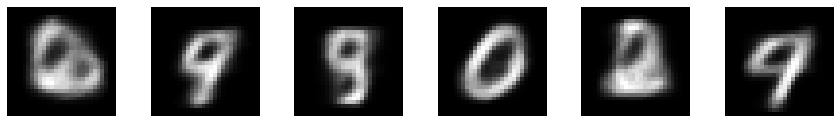


##################################################


100%|██████████| 938/938 [00:14<00:00, 66.99it/s]

VAE-MLP Epoch [2/7], Loss: 2.366114575449626
Sample Images:


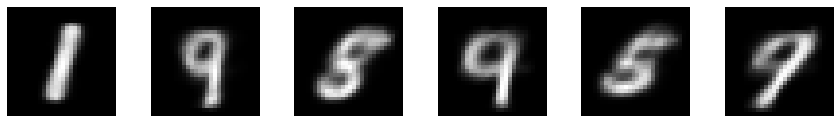


##################################################


100%|██████████| 938/938 [00:13<00:00, 68.08it/s]


VAE-MLP Epoch [3/7], Loss: 2.296933942667643
Sample Images:


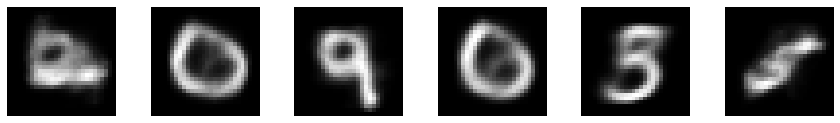


##################################################


100%|██████████| 938/938 [00:14<00:00, 62.62it/s]


VAE-MLP Epoch [4/7], Loss: 2.2588065095265706
Sample Images:


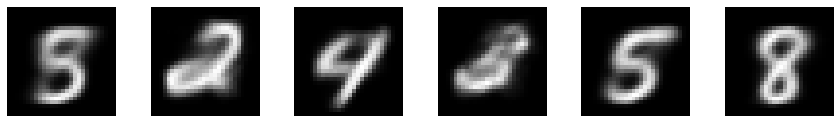


##################################################


100%|██████████| 938/938 [00:14<00:00, 66.62it/s]


VAE-MLP Epoch [5/7], Loss: 2.235155106099447
Sample Images:


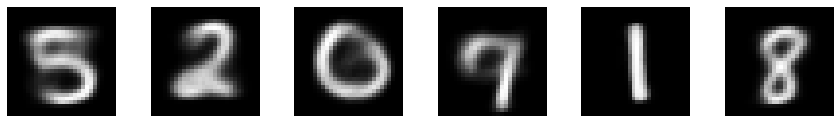


##################################################


100%|██████████| 938/938 [00:14<00:00, 64.21it/s]


VAE-MLP Epoch [6/7], Loss: 2.221010118484497
Sample Images:


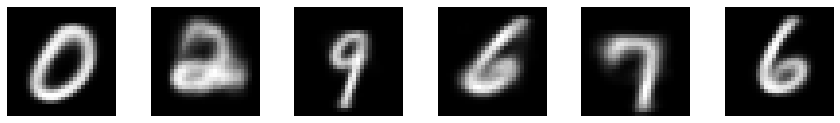


##################################################


100%|██████████| 938/938 [00:14<00:00, 65.67it/s]


VAE-MLP Epoch [7/7], Loss: 2.209621291732788
Sample Images:


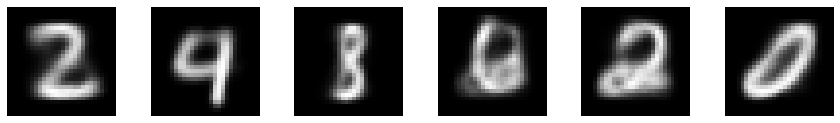

Best model saved as 'best_vae_mlp_model.pth'


In [8]:
# Train VAE-MLP

input_dim = 784  
hidden_dim = [1000,500,250]  # based on slides!
latent_dim = 2

vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)
vae_mlp = vae_mlp.to(device)

train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [38]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()

        encoder_layers = []
        encoder_layers.append(nn.Linear(input_dim + num_classes, hidden_dim[0]))
        encoder_layers.append(nn.ReLU())
        for i in range(len(hidden_dim) - 1):
            encoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(hidden_dim[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim[-1], latent_dim)
        self.fc_class = nn.Identity()

        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim + num_classes, hidden_dim[-1]))
        decoder_layers.append(nn.ReLU())
        for i in range(len(hidden_dim) - 1, 0, -1):
            decoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i-1]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(hidden_dim[0], input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):

        x = torch.cat([x, y], dim=1)

        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)

        class_logits = self.fc_class(y)
        zy = torch.cat([z, class_logits], dim=1)

        reconstructed = self.decoder(zy)

        return reconstructed, mu, logvar, class_logits, z


In [39]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):

    reconstruction_loss = nn.functional.binary_cross_entropy(recon.view(-1, 28*28), data.view(-1, 28*28), reduction='sum')

    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    total_loss = (reconstruction_loss + kl_divergence + ce_loss) / data.size(0)
    return total_loss


In [37]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    device = next(model.parameters()).device  # Get the device of the model
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for (data, labels) in tqdm(train_loader):
            data = data.to(device)  # Move data to the specified device
            labels = labels.to(device)
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            data = data.view(-1, 28*28)
            recon, mu, logvar, class_logits, _ = model(data, labels_one_hot)

            recon = recon.view(-1, 28*28)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2).to(device)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1).to(device)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################


  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:16<00:00, 55.49it/s]


CVAE-MLP Epoch [1/10], Loss: 2.443610730234782
Sample Images:


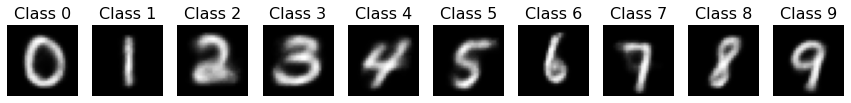


##################################################


100%|██████████| 938/938 [00:16<00:00, 56.36it/s]


CVAE-MLP Epoch [2/10], Loss: 2.142778224436442
Sample Images:


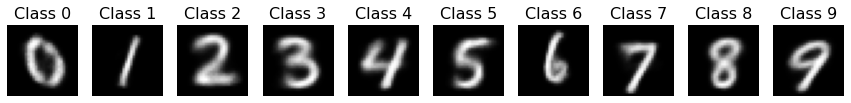


##################################################


100%|██████████| 938/938 [00:16<00:00, 57.37it/s]


CVAE-MLP Epoch [3/10], Loss: 2.1050903246561687
Sample Images:


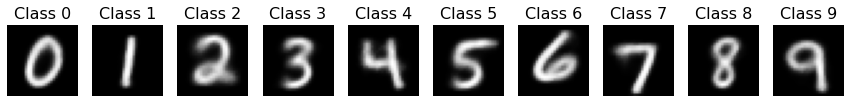


##################################################


100%|██████████| 938/938 [00:21<00:00, 44.25it/s]


CVAE-MLP Epoch [4/10], Loss: 2.0819165960947674
Sample Images:


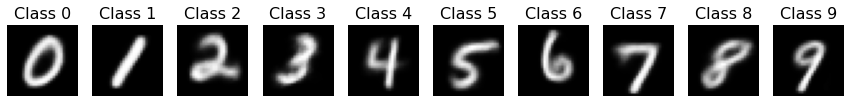


##################################################


100%|██████████| 938/938 [00:19<00:00, 47.13it/s]


CVAE-MLP Epoch [5/10], Loss: 2.0688131271362304
Sample Images:


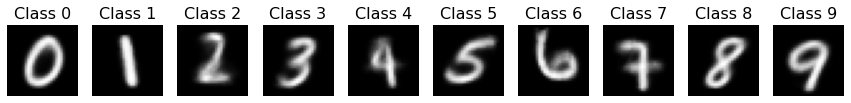


##################################################


100%|██████████| 938/938 [00:20<00:00, 44.91it/s]


CVAE-MLP Epoch [6/10], Loss: 2.058644856262207
Sample Images:


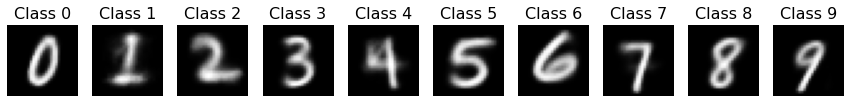


##################################################


100%|██████████| 938/938 [00:19<00:00, 49.10it/s]


CVAE-MLP Epoch [7/10], Loss: 2.0534710355122883
Sample Images:


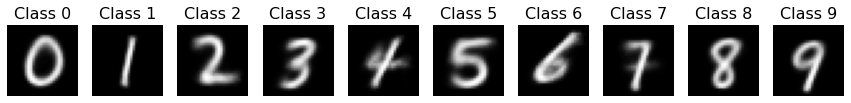


##################################################


100%|██████████| 938/938 [00:18<00:00, 49.83it/s]


CVAE-MLP Epoch [8/10], Loss: 2.0407534856160483
Sample Images:


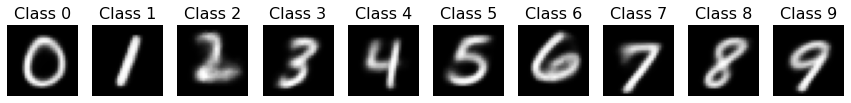


##################################################


100%|██████████| 938/938 [00:20<00:00, 45.68it/s]


CVAE-MLP Epoch [9/10], Loss: 2.035162642033895
Sample Images:


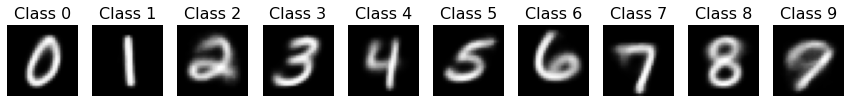


##################################################


100%|██████████| 938/938 [00:18<00:00, 50.10it/s]


CVAE-MLP Epoch [10/10], Loss: 2.0305193340301515
Sample Images:


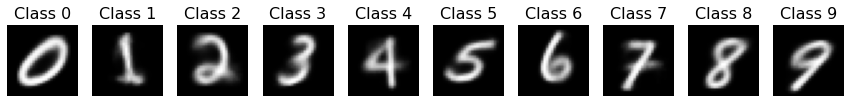

Best model saved as 'best_cvae_mlp_model.pth'


In [40]:
input_dim = 784  
hidden_dim = [1000,500,250]  # based on slides!
latent_dim = 2

cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes=10)
cvae_mlp = cvae_mlp.to(device)

train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


In [55]:
num_classes=10
# Load the models
vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)
cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)

vae_mlp.load_state_dict(torch.load('best_vae_mlp_model.pth'))
cvae_mlp.load_state_dict(torch.load('best_cvae_mlp_model.pth'))
vae_mlp = vae_mlp.to(device)
cvae_mlp = cvae_mlp.to(device)

vae_mlp.eval()
cvae_mlp.eval()

# Define a function to get latent representations from the encoder
def get_latents(model, data_loader, num_samples=500):
    latents = []
    labels_of_latents = []

    for batch_idx, (data, label) in enumerate(data_loader):
        if len(latents) >= num_samples:
            break

        data = data.to(device)  # Move data to the specified device
        label = label.to(device)
        data = data.view(-1, 28*28)
        with torch.no_grad():
            if isinstance(model, CVAE_MLP):
                labels_one_hot = F.one_hot(label, num_classes=10).float()
                _, _, _, _, z = model(data, labels_one_hot)
            else:
                _, _, _, z = model(data)

        latents.append(z.cpu())
        labels_of_latents.append(label.cpu())

    latents = np.concatenate(latents, axis=0)
    return latents, labels_of_latents

# Get latent representations from both models
vae_mlp_latents, vae_mlp_labels = get_latents(vae_mlp, train_loader)
cvae_mlp_latents, cvae_mlp_labels = get_latents(cvae_mlp, train_loader)



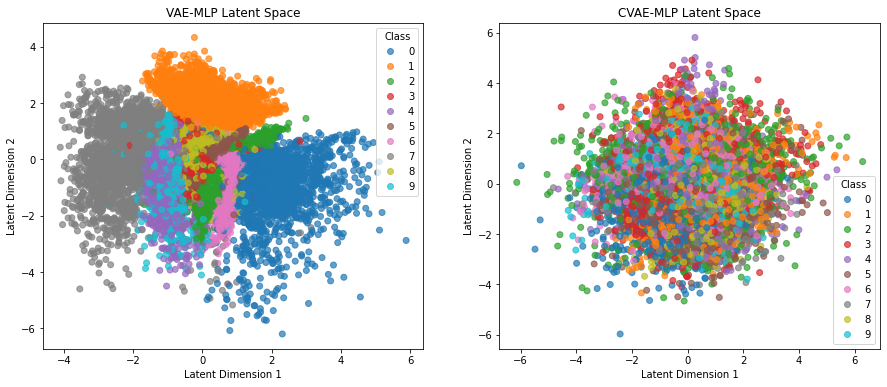

In [58]:
# Plot the latent space distributions
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot VAE-MLP latent space with tab10 colormap
scatter_vae = axs[0].scatter(vae_mlp_latents[:, 0], vae_mlp_latents[:, 1], c=vae_mlp_labels, cmap='tab10', label='VAE-MLP', alpha=0.7)
axs[0].set_title('VAE-MLP Latent Space')
axs[0].set_xlabel('Latent Dimension 1')
axs[0].set_ylabel('Latent Dimension 2')

# Plot CVAE-MLP latent space with tab10 colormap
scatter_cvae = axs[1].scatter(cvae_mlp_latents[:, 0], cvae_mlp_latents[:, 1], c=cvae_mlp_labels, cmap='tab10', label='CVAE-MLP', alpha=0.7)
axs[1].set_title('CVAE-MLP Latent Space')
axs[1].set_xlabel('Latent Dimension 1')
axs[1].set_ylabel('Latent Dimension 2')

# Add legends
legend_labels = [str(i) for i in range(10)]  # Assuming 10 classes
axs[0].legend(handles=scatter_vae.legend_elements()[0], labels=legend_labels, title='Class')
axs[1].legend(handles=scatter_cvae.legend_elements()[0], labels=legend_labels, title='Class')

plt.show()

generated images:


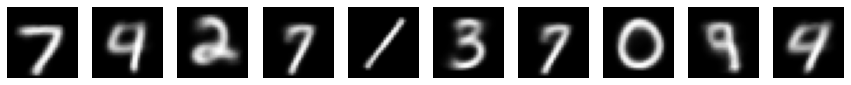

In [47]:
print("generated images using vae:")
num_samples = 10
with torch.no_grad():
    sample = torch.randn(num_samples, 2).to(device)
    sample = vae_mlp.decoder(sample).view(num_samples, 1, 28, 28)
    sample = sample.squeeze().cpu()
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
    for i in range(num_samples):
        axs[i].imshow(sample[i], cmap='gray')
        axs[i].axis('off')
    plt.show()

generated images using cvae:


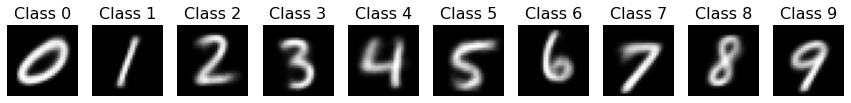

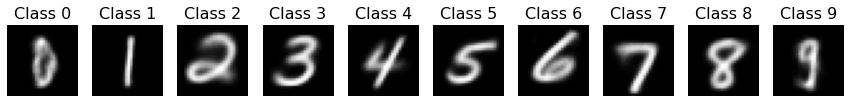

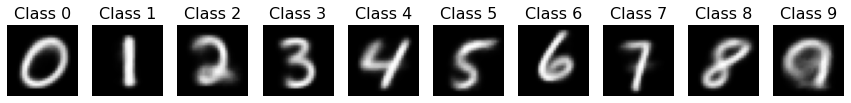

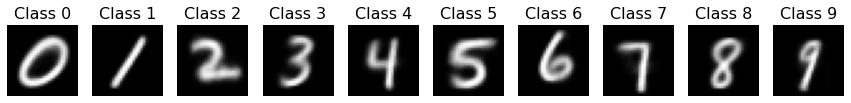

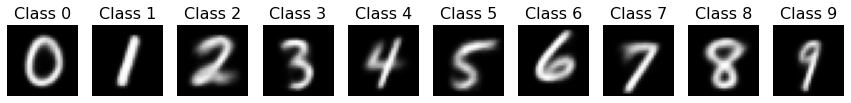

In [53]:
print("generated images using cvae:")
with torch.no_grad():
    for _ in range(5):
        num_classes = 10  # Number of classes (0 to 9)
        num_samples_per_class = 1  # One sample per class
        # Generate random samples
        z = torch.randn(num_classes * num_samples_per_class, 2).to(device)
        # Generate one-hot encoded class labels
        y = torch.eye(num_classes).repeat(num_samples_per_class, 1).to(device)
        # Concatenate the random samples and class labels before passing them to the decoder
        sample = torch.cat([z, y], dim=1)
        sample = cvae_mlp.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
        sample = sample.squeeze().cpu()
        fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
        for i in range(num_classes):
            axs[i].imshow(sample[i], cmap='gray')
            axs[i].set_title(f"Class {i}", fontsize=16)
            axs[i].axis('off')
        plt.show()